In [1]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Activity 2.3.3 - Abstracting away the learning model and non-linear transformations with `sklearn`'s `Pipeline` and `ColumnTransformer`

In the third part of this activity, we will illustrate methods for combining multiple grid searches into a single grid search.  This is useful because it allows us to abstract away the learning model and non-linear transformations, which can make our code more concise and easier to read.

## Example Data - `airquality.csv` 

We will be using a previous dataset `airquality.csv`, which involved some missing data as well as non-linearity, but this time we will explore modeling the non-linearity with either polynomial features or splines.

In [2]:
(airqual :=
 pl.read_csv("sample_data/airquality.csv")
   .drop('rownames')
)

Ozone,Solar.R,Wind,Temp,Month,Day
i64,i64,f64,i64,i64,i64
41,190,7.4,67,5,1
36,118,8.0,72,5,2
12,149,12.6,74,5,3
18,313,11.5,62,5,4
null,null,14.3,56,5,5
…,…,…,…,…,…
30,193,6.9,70,9,26
null,145,13.2,77,9,27
14,191,14.3,75,9,28


In [3]:
(aq_has_target :=
 airqual
 .filter(pl.col('Ozone').is_not_null())
)

Ozone,Solar.R,Wind,Temp,Month,Day
i64,i64,f64,i64,i64,i64
41,190,7.4,67,5,1
36,118,8.0,72,5,2
12,149,12.6,74,5,3
18,313,11.5,62,5,4
28,null,14.9,66,5,6
…,…,…,…,…,…
14,20,16.6,63,9,25
30,193,6.9,70,9,26
14,191,14.3,75,9,28


In [4]:
(aq_has_target_stacked :=
 aq_has_target
 .unpivot(on = cs.numeric() - cs.by_name('Ozone'),
          index = 'Ozone',
          variable_name = 'Feature',
          value_name = 'Value',
         )
)

Ozone,Feature,Value
i64,str,f64
41,"""Solar.R""",190.0
36,"""Solar.R""",118.0
12,"""Solar.R""",149.0
18,"""Solar.R""",313.0
28,"""Solar.R""",null
…,…,…
14,"""Day""",25.0
30,"""Day""",26.0
14,"""Day""",28.0


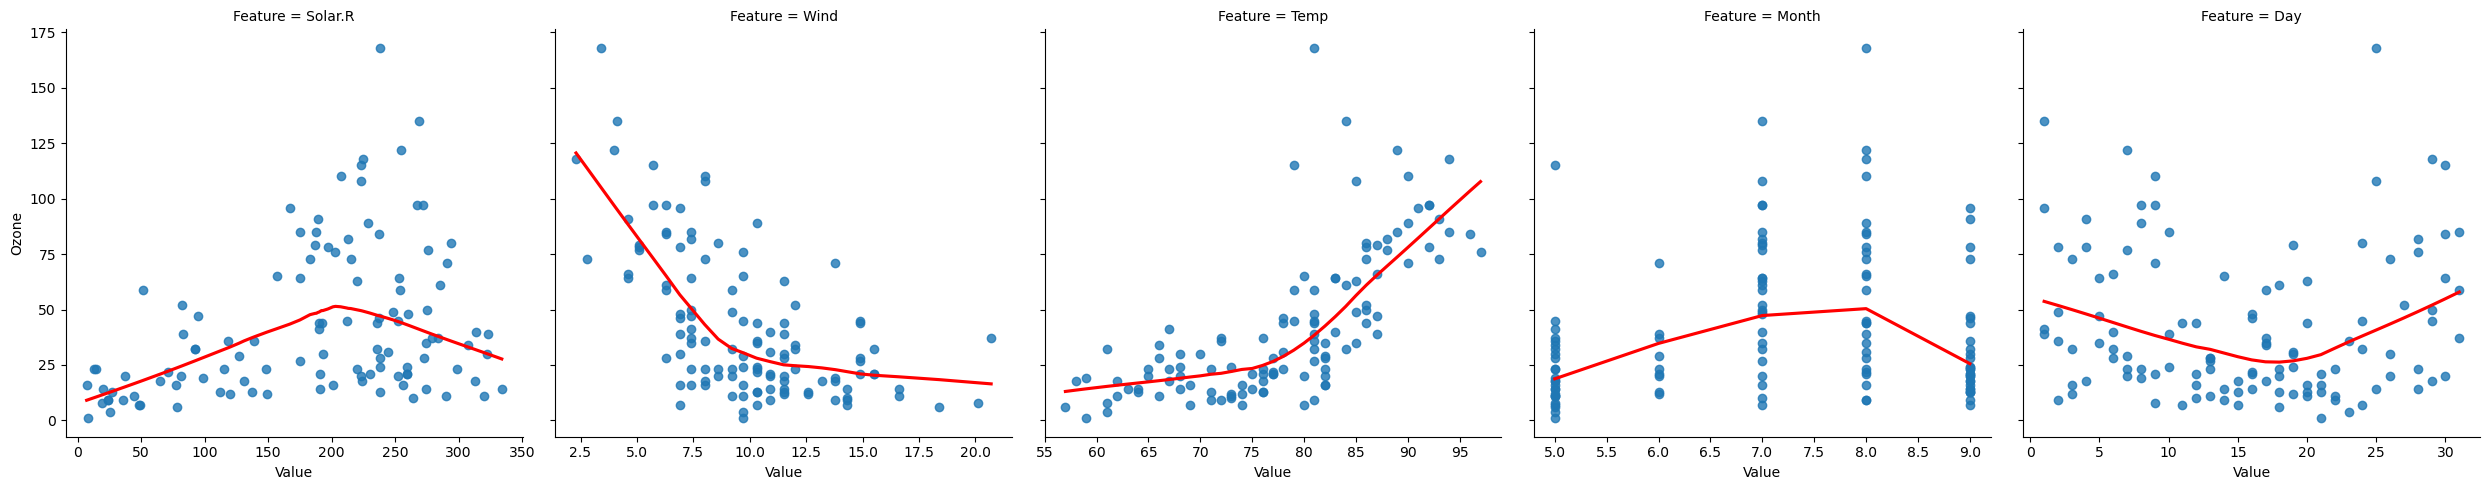

In [5]:
sns.lmplot(aq_has_target_stacked.to_pandas(),
           x = 'Value',
           y = 'Ozone',
           col = 'Feature',
           lowess = True,
           facet_kws = {'sharex':False,},
           line_kws={'color': 'red'},
           )

In [6]:
(X_train :=
 aq_has_target
 .drop('Ozone')
 .to_pandas()
 )

,Solar.R,Wind,Temp,Month,Day
0,190.0,7.4,67,5,1
1,118.0,8.0,72,5,2
2,149.0,12.6,74,5,3
3,313.0,11.5,62,5,4
4,NaN,14.9,66,5,6
...,...,...,...,...,...
111,20.0,16.6,63,9,25
112,193.0,6.9,70,9,26
113,191.0,14.3,75,9,28
114,131.0,8.0,76,9,29


In [7]:
(y_train :=
 aq_has_target
 .get_column('Ozone')
 .to_numpy()
)

array([ 41,  36,  12,  18,  28,  23,  19,   8,   7,  16,  11,  14,  18,
        14,  34,   6,  30,  11,   1,  11,   4,  32,  23,  45, 115,  37,
        29,  71,  39,  23,  21,  37,  20,  12,  13, 135,  49,  32,  64,
        40,  77,  97,  97,  85,  10,  27,   7,  48,  35,  61,  79,  63,
        16,  80, 108,  20,  52,  82,  50,  64,  59,  39,   9,  16,  78,
        35,  66, 122,  89, 110,  44,  28,  65,  22,  59,  23,  31,  44,
        21,   9,  45, 168,  73,  76, 118,  84,  85,  96,  78,  73,  91,
        47,  32,  20,  23,  21,  24,  44,  21,  28,   9,  13,  46,  18,
        13,  24,  16,  13,  23,  36,   7,  14,  30,  14,  18,  20])

In [8]:
(poly_complete :=
 make_pipeline(StandardScaler(), PolynomialFeatures())
)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('polynomialfeatures', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",2
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",True
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'


In [9]:
(poly_w_missing :=
 make_pipeline(SimpleImputer(),
               StandardScaler(),
               PolynomialFeatures()))

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('simpleimputer', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite i

In [10]:
(preprocessing :=
 make_column_transformer(
     (poly_complete, ['Wind']),
     (poly_complete, ['Temp']),
     (poly_complete, ['Month']),
     (poly_complete, ['Day']),
     (poly_w_missing, ['Solar.R']),
 )
)

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``fea

### Understanding `sklearn`'s `Pipeline` and `ColumnTransformer` naming conventions
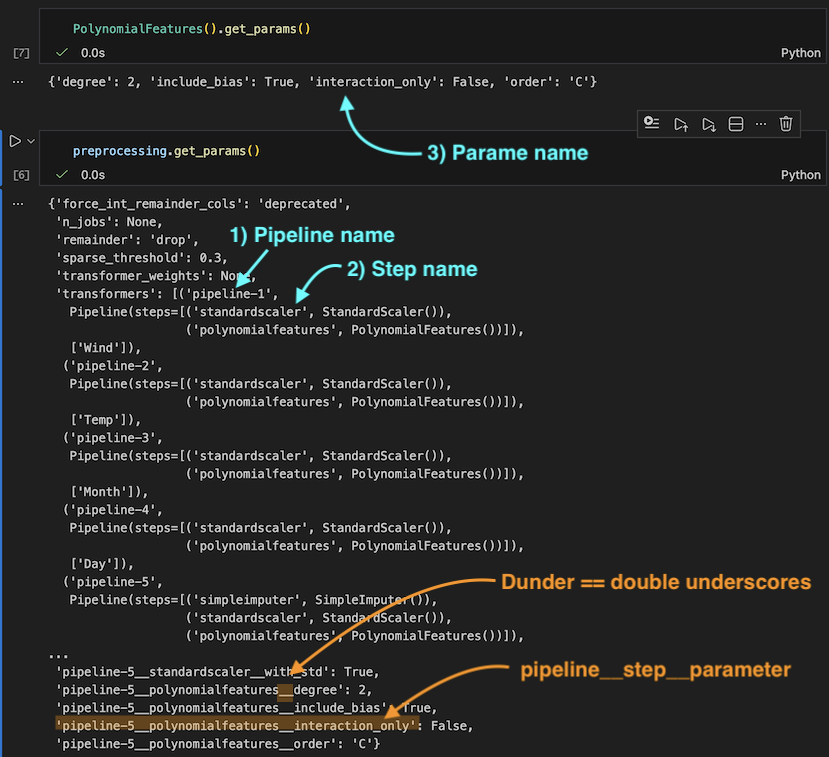

### Understanding `sklearn`'s `Pipeline` and `ColumnTransformer` naming conventions (cont.)

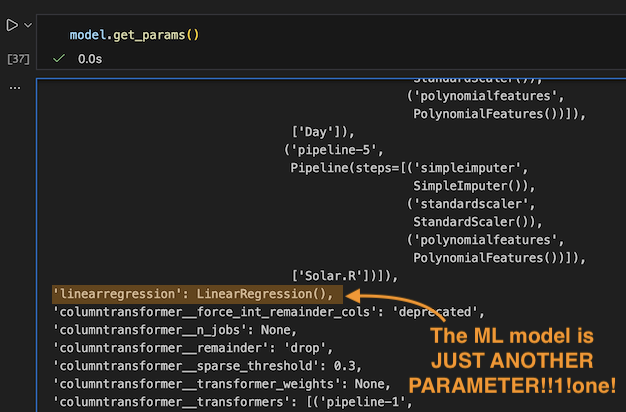

In [15]:
(model := 
  make_pipeline(preprocessing, LinearRegression()   
              )
)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the outp

### Understanding `sklearn`'s `Pipeline` and `ColumnTransformer` naming conventions (cont.)

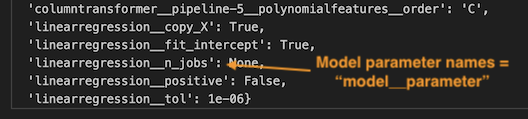

## Example 1 - Using a `TranformedTargetRegressor` to abstract away the learning model

First, we can use a `TransformedTargetRegressor` to abstract away the learning model.  This allows us to specify the learning model as part of the grid search parameters, rather than having to make a separate grid search for each learning method.

In [12]:
Y = np.array([1,2,3,4,5,6,7,8,9,10])
X = np.array([0,1,3,5,3,5,7,9,8,9]).reshape((-1, 1))

In [13]:
(model := TransformedTargetRegressor()
)

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",None
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",None
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True


In [14]:
(params := [
    {
        "regressor": [LinearRegression()],
        "regressor__fit_intercept": [True, False]
    },
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [2,3,4,5]
    }
]
)

[{'regressor': [LinearRegression()],
  'regressor__fit_intercept': [True, False]},
 {'regressor': [KNeighborsRegressor()],
  'regressor__n_neighbors': [2, 3, 4, 5]}]

In [25]:
g = GridSearchCV(model, params)
g.fit(X, Y)

g.best_estimator_, g.best_score_, g.best_params_

ValueError: Invalid parameter 'regressor' for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['Wind']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['Temp']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('stand...
                                                                   PolynomialFeatures())]),
                                                  ['Month']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['Day']),
                                                 ('pipeline-5',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['Solar.R'])])),
                ('linearregression', LinearRegression())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

In [20]:
(example_transformed_regressor :=
 TransformedTargetRegressor()
)

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",None
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",None
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True


## Example 2 - Abstracting away the regressor selections with a preprocessor

**Before.**
1. Make a separate grid search for each learning method (e.g., OLS and kNN),
2. perform the grid search for each learning method, and
3. compare the CV MSE to determine which model performed the best.

**After.**
1. Make a single grid search that includes incorporates both learning methods (e.g., OLS and kNN) as part of the grid search parameters, and
2. Perform the grid search and compare the CV MSE to determine which model performed the best.

In [22]:
(generic_model :=
  make_pipeline(preprocessing, TransformedTargetRegressor())
)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('transformedtargetregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3I

In [23]:
[p for p in generic_model.get_params() if 'degree' in p or 'regressor' in p]

['transformedtargetregressor',
 'columntransformer__pipeline-1__polynomialfeatures__degree',
 'columntransformer__pipeline-2__polynomialfeatures__degree',
 'columntransformer__pipeline-3__polynomialfeatures__degree',
 'columntransformer__pipeline-4__polynomialfeatures__degree',
 'columntransformer__pipeline-5__polynomialfeatures__degree',
 'transformedtargetregressor__check_inverse',
 'transformedtargetregressor__func',
 'transformedtargetregressor__inverse_func',
 'transformedtargetregressor__regressor',
 'transformedtargetregressor__transformer']

In [24]:
(shared_params :=
 {'columntransformer__pipeline-1__polynomialfeatures__degree':[1,2,3],
  'columntransformer__pipeline-2__polynomialfeatures__degree': [1,2,3],
  'columntransformer__pipeline-3__polynomialfeatures__degree': [1,2,3],
  'columntransformer__pipeline-4__polynomialfeatures__degree': [1,2,3],
  'columntransformer__pipeline-5__polynomialfeatures__degree': [1,2,3],
})

{'columntransformer__pipeline-1__polynomialfeatures__degree': [1, 2, 3],
 'columntransformer__pipeline-2__polynomialfeatures__degree': [1, 2, 3],
 'columntransformer__pipeline-3__polynomialfeatures__degree': [1, 2, 3],
 'columntransformer__pipeline-4__polynomialfeatures__degree': [1, 2, 3],
 'columntransformer__pipeline-5__polynomialfeatures__degree': [1, 2, 3]}

In [26]:
KNeighborsRegressor().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [27]:
(parameters := 
 [
     shared_params | {'transformedtargetregressor__regressor':[LinearRegression()]},
     shared_params | {'transformedtargetregressor__regressor':[KNeighborsRegressor()], 'transformedtargetregressor__regressor__n_neighbors':[2,3,4,5]}
 ]
)

[{'columntransformer__pipeline-1__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-2__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-3__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-4__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-5__polynomialfeatures__degree': [1, 2, 3],
  'transformedtargetregressor__regressor': [LinearRegression()]},
 {'columntransformer__pipeline-1__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-2__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-3__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-4__polynomialfeatures__degree': [1, 2, 3],
  'columntransformer__pipeline-5__polynomialfeatures__degree': [1, 2, 3],
  'transformedtargetregressor__regressor': [KNeighborsRegressor()],
  'transformedtargetregressor__regressor__n_neighbors': [2, 3, 4, 5]}]

In [28]:
(combined_grid_search :=
 GridSearchCV(generic_model, parameters, cv=5, n_jobs=-1, verbose=3)
 )

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Regressor())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], ...}, {'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is u

In [29]:
combined_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Regressor())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], ...}, {'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], 'columntransformer__pip...ynomialfeatures__degree': [1, 2, ...], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is u

In [30]:
combined_grid_search.best_estimator_, combined_grid_search.best_score_, combined_grid_search.best_params_

(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline-1',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler()),
                                                                   ('polynomialfeatures',
                                                                    PolynomialFeatures())]),
                                                   ['Wind']),
                                                  ('pipeline-2',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler()),
                                                                   ('polynomialfeatures',
                                                                    PolynomialFeatures(degree=3))]),
                                                 

### Using `Pipeline` and `ColumnTransformer` to specify step names

We can use the `Pipeline` and `ColumnTransformer` objects to specify the names of the steps in our preprocessing.  This can be helpful for interpreting the results of a grid search, as it allows us to easily identify which steps correspond to which parameters.

In [31]:
(poly_complete :=
 Pipeline(
     steps= [('scale', StandardScaler()),
             ('poly', PolynomialFeatures())
     ]
     )
 )

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scale', ...), ('poly', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",2
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",True
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'


In [32]:
(poly_w_missing :=
 Pipeline(
     steps= [('impute', SimpleImputer()),
             ('scale', StandardScaler()),
             ('poly', PolynomialFeatures())
     ]
     )
 )

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('scale', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a 

In [33]:
poly_complete.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('poly', PolynomialFeatures())],
 'transform_input': None,
 'verbose': False,
 'scale': StandardScaler(),
 'poly': PolynomialFeatures(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C'}

In [34]:
poly_w_missing.get_params()

{'memory': None,
 'steps': [('impute', SimpleImputer()),
  ('scale', StandardScaler()),
  ('poly', PolynomialFeatures())],
 'transform_input': None,
 'verbose': False,
 'impute': SimpleImputer(),
 'scale': StandardScaler(),
 'poly': PolynomialFeatures(),
 'impute__add_indicator': False,
 'impute__copy': True,
 'impute__fill_value': None,
 'impute__keep_empty_features': False,
 'impute__missing_values': nan,
 'impute__strategy': 'mean',
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'poly__order': 'C'}

In [35]:
(preprocessing_poly :=
 ColumnTransformer(
        [
           ('wind',poly_complete, ['Wind']),
           ('temp',poly_complete, ['Temp']),
           ('month',poly_complete, ['Month']),
           ('day',poly_complete, ['Day']),
           ('solar',poly_w_missing, ['Solar.R']),
        ]
     )
 )

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('wind', ...), ('temp', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``.

In [36]:
preprocessing_poly.get_params()

{'force_int_remainder_cols': 'deprecated',
 'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('wind',
   Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
   ['Wind']),
  ('temp',
   Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
   ['Temp']),
  ('month',
   Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
   ['Month']),
  ('day',
   Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
   ['Day']),
  ('solar',
   Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                   ('poly', PolynomialFeatures())]),
   ['Solar.R'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'wind': Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
 'temp': Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures())]),
 'month': Pipeline(steps=[(

## Example 3 - Abstracting away the non-linear transformations with a preprocessor

Finally, we can use a `ColumnTransformer` to abstract away the non-linear transformations.  This allows us to specify the non-linear transformations as part of the grid search parameters, rather than having to make a separate grid search for each non-linear transformation.

In [37]:
(non_linear_complete :=
 Pipeline(
     steps=[('scale', StandardScaler()),
            ('non_linear_transform', None)
     ]
 )
)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scale', ...), ('non_linear_transform', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [38]:
(non_linear_w_missing :=
 Pipeline(
     steps=[('impute', SimpleImputer()),
            ('scale', StandardScaler()),
            ('non_linear_transform', None)
     ]
 )
)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('scale', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a 

In [39]:
(preprocessing_non_linear :=
 ColumnTransformer(
        [
           ('wind',  non_linear_complete, ['Wind']),
           ('temp',  non_linear_complete, ['Temp']),
           ('month', non_linear_complete, ['Month']),
           ('day',   non_linear_complete, ['Day']),
           ('solar', non_linear_w_missing, ['Solar.R']),
        ]
     )
 )

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('wind', ...), ('temp', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``.

In [40]:
(model_w_non_linear := 
  Pipeline(
      steps= [ ('preprocess', preprocessing_non_linear),
               ('model', LinearRegression())
      ]
  )
 )

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('wind', ...), ('temp', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [41]:
(base_names :=
[p for p in model_w_non_linear.get_params() if 'non_linear' in p]
)

['preprocess__wind__non_linear_transform',
 'preprocess__temp__non_linear_transform',
 'preprocess__month__non_linear_transform',
 'preprocess__day__non_linear_transform',
 'preprocess__solar__non_linear_transform']

In [42]:
PolynomialFeatures().get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [43]:
SplineTransformer().get_params()

{'degree': 3,
 'extrapolation': 'constant',
 'handle_missing': 'error',
 'include_bias': True,
 'knots': 'uniform',
 'n_knots': 5,
 'order': 'C',
 'sparse_output': False}

In [44]:
(non_linear_parameters :=
 # Polynomial parameters
 [ 
   # Base transformer
   {f'{base}':[PolynomialFeatures()]
    for base in base_names
   }
   |
   # Transform param 1
   {f'{base}__degree':[1,2,3]
    for base in base_names
   }
   |
   # Transform param 2
   {
    f'{base}__include_bias':[True, False]
    for base in base_names

   }
  ] 
 # Spline parameters
+  [ 
   # Base transformer
     {f'{base}':[SplineTransformer()]
       for base in base_names
     }
     |
   # Transform param 1
     {f'{base}__n_knots':[2,3,4]
      for base in base_names
     }
  ]
)

[{'preprocess__wind__non_linear_transform': [PolynomialFeatures()],
  'preprocess__temp__non_linear_transform': [PolynomialFeatures()],
  'preprocess__month__non_linear_transform': [PolynomialFeatures()],
  'preprocess__day__non_linear_transform': [PolynomialFeatures()],
  'preprocess__solar__non_linear_transform': [PolynomialFeatures()],
  'preprocess__wind__non_linear_transform__degree': [1, 2, 3],
  'preprocess__temp__non_linear_transform__degree': [1, 2, 3],
  'preprocess__month__non_linear_transform__degree': [1, 2, 3],
  'preprocess__day__non_linear_transform__degree': [1, 2, 3],
  'preprocess__solar__non_linear_transform__degree': [1, 2, 3],
  'preprocess__wind__non_linear_transform__include_bias': [True, False],
  'preprocess__temp__non_linear_transform__include_bias': [True, False],
  'preprocess__month__non_linear_transform__include_bias': [True, False],
  'preprocess__day__non_linear_transform__include_bias': [True, False],
  'preprocess__solar__non_linear_transform__include

In [45]:
(non_linear_grid_search :=
 GridSearchCV(model_w_non_linear,non_linear_parameters, cv=5, n_jobs=-1, verbose=3 )
)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'preprocess__day__non_linear_transform': [PolynomialFeatures()], 'preprocess__day__non_linear_transform__degree': [1, 2, ...], 'preprocess__day__non_l...transform__include_bias': [True, False], 'preprocess__month__non_linear_transform': [PolynomialFeatures()], ...}, {'preprocess__day__non_linear_transform': [SplineTransformer()], 'preprocess__day__non_linear_transform__n_knots': [2, 3, ...], 'preprocess__month__non_linear_transform': [SplineTransformer()], 'preprocess__month__non_linear_transform__n_knots': [2, 3, ...], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is us

In [46]:
non_linear_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8019 candidates, totalling 40095 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'preprocess__day__non_linear_transform': [PolynomialFeatures()], 'preprocess__day__non_linear_transform__degree': [1, 2, ...], 'preprocess__day__non_l...transform__include_bias': [True, False], 'preprocess__month__non_linear_transform': [PolynomialFeatures()], ...}, {'preprocess__day__non_linear_transform': [SplineTransformer()], 'preprocess__day__non_linear_transform__n_knots': [2, 3, ...], 'preprocess__month__non_linear_transform': [SplineTransformer()], 'preprocess__month__non_linear_transform__n_knots': [2, 3, ...], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is us

In [ ]:
non_linear_grid_search.best_estimator_, non_linear_grid_search.best_score_, non_linear_grid_search.best_params_


(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('wind',
                                                   Pipeline(steps=[('scale',
                                                                    StandardScaler()),
                                                                   ('non_linear_transform',
                                                                    PolynomialFeatures(degree=3))]),
                                                   ['Wind']),
                                                  ('temp',
                                                   Pipeline(steps=[('scale',
                                                                    StandardScaler()),
                                                                   ('non_linear_transform',
                                                                    PolynomialFeatures(include_bias=False))]),
                                                   ['Temp']),
  

: 

## <font color="red">Exercise 2.5.3 </font>

**Task.** Write a short summary of the steps you would take to combine the approaches in Examples 2-3, that is 
1. abstract away the learning model selections with a `TransformedTargetRegressor`, and
2. abstract away the non-linear transformations with a `ColumnTransformer`.

<font color="orange">
Your answer here.
</font>



#### The following is the answer to question 1. We'd want to use the Transformed Target Regressor in the Pipeline for learning model selections like was done in both the beginnning cells of example one, where we managed to successfully specify the learning model as part of the grid search parameters, as opposed to making a whole new separate grid for both Linear Rergression and kNN by passing the regressor as a variable for param_grid. I would do the same for both kNN and linear regression, with us switching between the kNN and linear (basically create a Transformed Target Regressor for both) and also utilize both Polynomial Features for the 'non-linear' features and the Spline Features for the 'linear features'. This will help us decide which algorithms are the best from both linear and kNN regression.  


#### The following is the answer to question 2. To abstract away the non-linear transformations we'd want to us column transformer on boht polynomial and spline features (which are both non-linear functions) which would allow us to do the transformations that are necessary to make the graph linear without having to do the 'extra math' that is required in many parameters of these methods (for example squaring them) 'ColumnTransformer' takes care of that process already.   
 